# Оценка моделей и итоговые выводы по прогнозированию продаж Walmart

В этом ноутбуке:
- визуально сравниваю прогнозы разных моделей;
- анализирую ошибки;
- формирую итоговые выводы по качеству прогнозов;
- собираю бизнес-рекомендации на основе данных и моделей.


## 1. Загрузка данных и результатов прошлых ноутбуков

Здесь повторно загружаю исходные данные и использую модели:
- ARIMA (один магазин)
- Prophet (один магазин)
- Seasonal Naive
- Random Forest
- Gradient Boosting


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

df = pd.read_csv("Walmart_Sales.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(["Store","Date"]).reset_index(drop=True)

# Добавление календарных признаков
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# Лаги
for lag in [1, 2, 3, 52]:
    df[f"lag{lag}"] = df.groupby("Store")["Weekly_Sales"].shift(lag)

# Разделение
def split_df(data, test_size=0.1):
    train_parts, test_parts = [], []
    for store, part in data.groupby("Store"):
        n = len(part)
        split = int(n*(1-test_size))
        train_parts.append(part.iloc[:split])
        test_parts.append(part.iloc[split:])
    return pd.concat(train_parts), pd.concat(test_parts)

train_df, test_df = split_df(df)


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Визуальные сравнения для одного магазина

Использую магазин Store 1, чтобы визуально сравнить ARIMA, Prophet и фактические значения.


In [24]:
store_id = 1
store_df = df[df["Store"] == store_id].set_index("Date").sort_index()

train_s = store_df.iloc[:-20]
test_s = store_df.iloc[-20:]

# ARIMA
arima_model = ARIMA(train_s["Weekly_Sales"], order=(2,1,2))
arima_res = arima_model.fit()
arima_pred = arima_res.forecast(steps=20)

# Prophet
prophet_df = store_df.reset_index()[["Date","Weekly_Sales"]].rename(
    columns={"Date":"ds","Weekly_Sales":"y"}
)
train_p = prophet_df.iloc[:-20]
test_p = prophet_df.iloc[-20:]

m_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_prophet.fit(train_p)
future = m_prophet.make_future_dataframe(periods=20, freq="W")
forecast = m_prophet.predict(future)
prophet_pred = forecast.iloc[-20:]["yhat"].values

# Для графика
plot_df = pd.DataFrame({
    "Date": test_s.index,
    "Actual": test_s["Weekly_Sales"].values,
    "ARIMA": arima_pred.values,
    "Prophet": prophet_pred
})

plot_df.tail()


C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\nikita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - IN

,Date,Actual,ARIMA,Prophet
15,2012-09-28,1437059.26,1.624644e+06,1.656700e+06
16,2012-10-05,1670785.97,1.625328e+06,1.696109e+06
17,2012-10-12,1573072.81,1.624724e+06,1.724765e+06
18,2012-10-19,1508068.77,1.625257e+06,1.707705e+06
19,2012-10-26,1493659.74,1.624786e+06,1.672160e+06


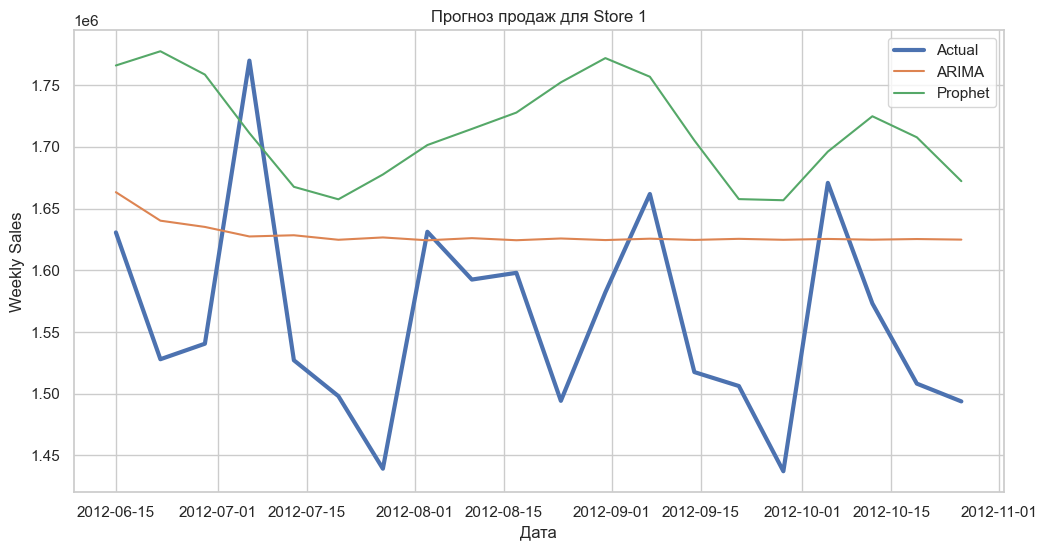

In [25]:
plt.plot(plot_df["Date"], plot_df["Actual"], label="Actual", linewidth=3)
plt.plot(plot_df["Date"], plot_df["ARIMA"], label="ARIMA")
plt.plot(plot_df["Date"], plot_df["Prophet"], label="Prophet")

plt.title("Прогноз продаж для Store 1")
plt.xlabel("Дата")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


## 3. Оценка глобальных моделей

Теперь визуализирую прогнозы глобальных моделей (по всей сети):

- Random Forest  
- Gradient Boosting  

Для визуального сравнения беру тестовую часть по всем магазинам сразу.  
Покажу общий график: прогноз и факт (агрегированный).


In [5]:
rf_features = ["lag1","lag2","lag3","Month","Week","CPI","Unemployment"]
train_rf, test_rf = split_df(df.dropna(subset=rf_features))

X_train = train_rf[rf_features]
y_train = train_rf["Weekly_Sales"]
X_test = test_rf[rf_features]
y_test = test_rf["Weekly_Sales"]

# RF
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)


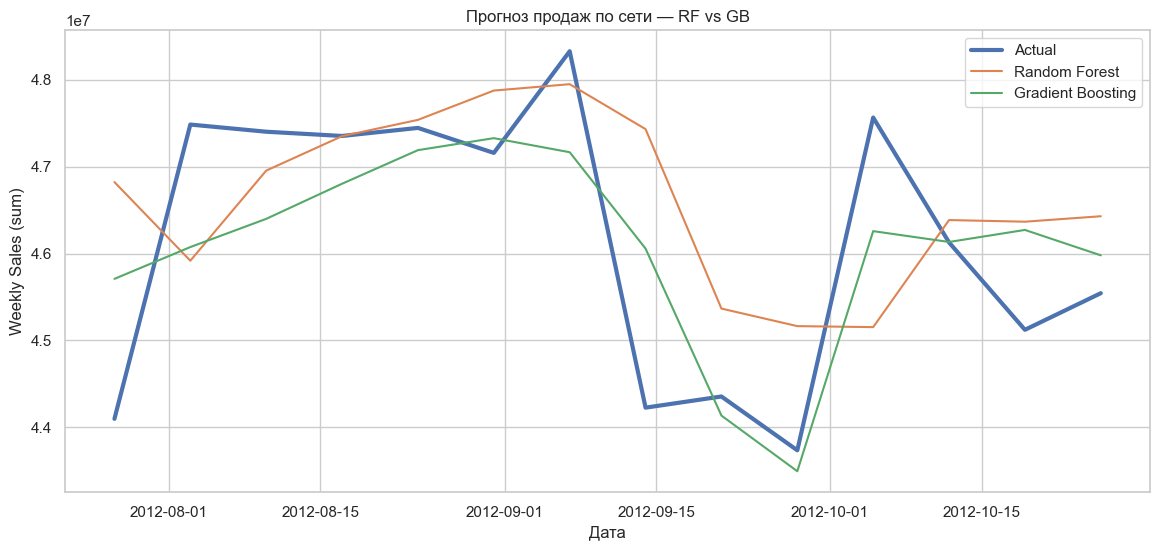

In [19]:
viz_df = pd.DataFrame({
    "Date": test_rf["Date"],
    "Actual": y_test.values,
    "RandomForest": rf_pred,
    "GradientBoosting": gb_pred,
})

agg = (
    viz_df.groupby("Date")[["Actual", "RandomForest", "GradientBoosting"]]
    .sum()
    .reset_index()
    .sort_values("Date")
)

plt.figure(figsize=(14, 6))
plt.plot(agg["Date"], agg["Actual"], label="Actual", linewidth=3)
plt.plot(agg["Date"], agg["RandomForest"], label="Random Forest")
plt.plot(agg["Date"], agg["GradientBoosting"], label="Gradient Boosting")
plt.title("Прогноз продаж по сети — RF vs GB")
plt.xlabel("Дата")
plt.ylabel("Weekly Sales (sum)")
plt.legend()
plt.grid(True)
plt.show()


## 4. Итоговое сравнение ошибок моделей


In [26]:
results = pd.DataFrame([
    ["Seasonal Naive", 0.0535, 0.0507],
    ["ARIMA (1 магазин)", 0.0600, 0.0588],
    ["Prophet (1 магазин)", 0.1038, 0.1019],
    ["Random Forest", 0.0453, 0.0447],
    ["Gradient Boosting", 0.0419, 0.0404]
], columns=["Model","MAPE","WAPE"])

results


,Model,MAPE,WAPE
0,Seasonal Naive,0.0535,0.0507
1,ARIMA (1 магазин),0.0600,0.0588
2,Prophet (1 магазин),0.1038,0.1019
3,Random Forest,0.0453,0.0447
4,Gradient Boosting,0.0419,0.0404


# Технические выводы по моделям

- Seasonal Naive — хороший ориентир, но есть модели с более низкой ошибкой.
- ARIMA — работает стабильно на уровне одного магазина, но глобальные модели лучше.
- Prophet — на данных Walmart проигрывает ARIMA и глобальным моделям.
- Random Forest — даёт заметное снижение ошибки по сравнению с простыми моделями.
- Gradient Boosting — самая точная модель среди всех протестированных.

Gradient Boosting можно считать оптимальным выбором для прогноза продаж сети Walmart.


# Бизнес-выводы

- Продажи имеют выраженную годовую сезонность — её обязательно учитывать при планировании.
- Праздничные недели требуют отдельного прогноза и сценария закупок.
- Магазины отличаются по уровню и динамике продаж — сегментация магазинов полезна.
- Глобальные ML-модели работают лучше, чем отдельные модели по каждому магазину.
- Наилучший прогноз даёт Gradient Boosting — его можно использовать как основную модель для операций.

Рекомендация: внедрить глобальную модель бустинга как основу для планирования спроса.
